이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter10_dl-for-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

# 시계열을 위한 딥러닝

## 다양한 종류의 시계열 작업

## 기온 예측 문제

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-02-03 06:41:09--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.139.112, 52.217.88.238, 52.216.54.200, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.139.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  1.64MB/s    in 15s     

2023-02-03 06:41:25 (871 KB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**예나 날씨 데이터셋 조사하기**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**데이터 파싱**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
temperature.shape

(420451,)

In [5]:
raw_data = np.zeros((len(lines), len(header) - 1))
print("raw_data.shape=", raw_data.shape)
counts = 0
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    if (counts == 0):
      print("values=", values)
      print("values[:]=", values[1])
      print("values[:]=", values[:])

    temperature[i] = values[1]
    raw_data[i, :] = values[:]
    counts += 1

raw_data.shape= (420451, 14)
values= [996.52, -8.02, 265.4, -8.9, 93.3, 3.33, 3.11, 0.22, 1.94, 3.12, 1307.75, 1.03, 1.75, 152.3]
values[:]= -8.02
values[:]= [996.52, -8.02, 265.4, -8.9, 93.3, 3.33, 3.11, 0.22, 1.94, 3.12, 1307.75, 1.03, 1.75, 152.3]


**전체 기온을 그래프로 그리기**

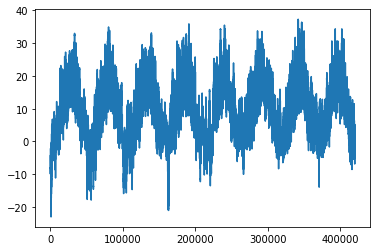

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

**처음 10일간의 기온을 그래프로 그리기**

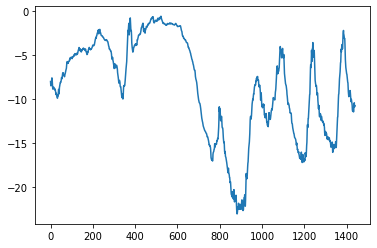

In [7]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**각 분할에 사용할 샘플 수 계산하기**

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 데이터 준비

**데이터 정규화**

In [11]:
raw_data.shape

(420451, 14)

In [13]:
mean = raw_data[:num_train_samples].mean(axis=0)
print(mean.shape)
print(mean)

(14,)
[ 2.05609361e-11 -1.26011024e-13  5.93749350e-12 -1.23830720e-13
 -8.74303698e-14 -1.84913740e-14 -4.34931751e-14 -9.24635963e-14
  1.22715902e-13 -1.50654917e-14 -8.68490108e-12  2.50996158e-14
 -1.28225578e-13 -8.68223770e-13]


In [14]:
raw_data[0]

array([  7.77070534, -16.84590329, -17.5050718 , -13.21331863,
        17.42724524,  -9.81569946,  -6.08414209,  -3.73148184,
        -3.87050741,  -6.18208943,  89.29795985,  -1.11977462,
        -1.81048029, -24.1405232 ])

In [12]:
raw_data -= mean
raw_data.shape

(420451, 14)

In [15]:
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [16]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**훈련, 검증, 테스트 데이터셋 만들기**

In [17]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**훈련 데이터셋의 배치 크기 확인하기**

In [18]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


### 상식 수준의 기준점

**상식적인 기준 모델의 MAE 계산하기**

In [19]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 8.83
테스트 MAE: 8.87


### 기본적인 머신 러닝 모델 시도해 보기

**밀집 연결 모델 훈련하고 평가하기**

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

**결과 그래프 그리기**

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 1D 합성곱 모델 시도해 보기

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 첫 번째 순환 신경망

**간단한 LSTM 기반 모델**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 순환 신경망 이해하기

**넘파이로 구현한 간단한 RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### 케라스의 순환 층

**어떤 길이의 시퀀스도 처리할 수 있는 RNN 층**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**마지막 출력 스텝만 반환하는 RNN 층**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

**전체 출력 시퀀스를 반환하는 RNN 층**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

**스태킹(stacking) RNN 층**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## 순환 신경망의 고급 사용법

### 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

**드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

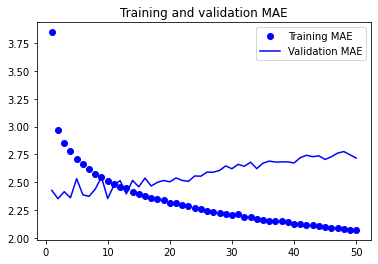

In [22]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model.predict()

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### 스태킹 순환 층

**드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
# x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 양방향 RNN 사용하기

시퀀스를 거꾸로 뒤집어 LSTM 모델 훈련하기 (책에는 없음)

In [ ]:
def train_generator():
    while True:
        for samples, targets in train_dataset:
            yield samples[:, ::-1, :], targets

def val_generator():
    while True:
        for samples, targets in val_dataset:
            yield samples[:, ::-1, :], targets
        
train_gen = train_generator()
val_gen = val_generator()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=819,
                    validation_data=val_gen,
                    validation_steps=410)

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**양방향 LSTM 모델 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### 더 나아가서

## 요약